### Packages

#### Install additional packages

#### Import packages

In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

### Code

#### Import dataset

In [2]:
dataset = load_dataset("timdettmers/openassistant-guanaco")

Repo card metadata block was not found. Setting CardData to empty.


#### Analysis of dataset

In [3]:
print("Dataset Structure:\n", dataset)
print("\nAvailable Splits:", dataset.keys())

Dataset Structure:
 DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text'],
        num_rows: 518
    })
})

Available Splits: dict_keys(['train', 'test'])


In [4]:
train_df = pd.DataFrame(dataset['train'], columns=['text'])
test_df = pd.DataFrame(dataset['test'], columns=['text'])

In [5]:
df = pd.concat([train_df, test_df], axis=0)

In [6]:
print("\nFirst few entries of the dataset:")
print(df.head())


First few entries of the dataset:
                                                text
0  ### Human: Can you write a short introduction ...
1  ### Human: ¿CUales son las etapas del desarrol...
2  ### Human: Can you explain contrastive learnin...
3  ### Human: I want to start doing astrophotogra...
4  ### Human: Método del Perceptrón biclásico: de...


##### Example of Human - Assistant Interaction

In [7]:
df.iloc[0]['text'].split("###")

['',
 ' Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
 ' Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power,

##### Sentence length analysis

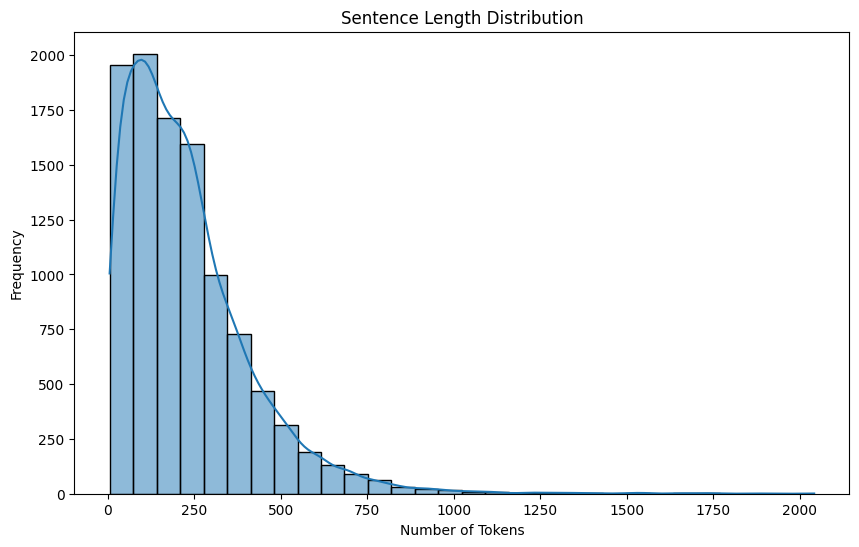

In [8]:
df['token_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['token_length'], bins=30, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [9]:
min_length = df['token_length'].min()
max_length = df['token_length'].max()
avg_length = df['token_length'].mean()

print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Average Length: {avg_length}")

Minimum Length: 5
Maximum Length: 2041
Average Length: 226.36896950984175


#### Search Engine

In [36]:
import pyterrier as pt

if not pt.started():
    pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8



In [37]:
df["docno"] = [str(i) for i in range(1, len(df) + 1)]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10364 entries, 0 to 517
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          10364 non-null  object
 1   token_length  10364 non-null  int64 
 2   docno         10364 non-null  object
dtypes: int64(1), object(2)
memory usage: 581.9+ KB


In [39]:
indexer = pt.DFIndexer(
    "c:\\Users\\filip\\Desktop\\NLP-project\\local\\index", overwrite=True
)
index_ref = indexer.index(df["text"], df["docno"])
index_ref.toString()

10:23:47.649 [main] ERROR org.terrier.structures.indexing.Indexer - Could not rename index
java.io.IOException: Rename of index structure file 'c:\Users\filip\Desktop\NLP-project\local\index/data_1.direct.bf' (exists) to 'c:\Users\filip\Desktop\NLP-project\local\index/data.direct.bf' (exists) failed - likely that source file is still open. Possible indexing bug?
	at org.terrier.structures.IndexUtil.renameIndex(IndexUtil.java:379)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:355)


'c:\\Users\\filip\\Desktop\\NLP-project\\local\\index/data.properties'

In [40]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 9846
Number of terms: 72009
Number of postings: 780518
Number of fields: 0
Number of tokens: 1510591
Field names: []
Positions:   false



In [43]:
query = "human"

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query).head(10)

,qid,docid,docno,rank,score,query
0,1,5945,5946,0,-2.890922,human
1,1,2133,2134,1,-3.129350,human
2,1,6641,6642,2,-3.525259,human
3,1,5300,5301,3,-3.546290,human
4,1,6720,6721,4,-4.752952,human
5,1,6437,6438,5,-4.808486,human
6,1,1666,1667,6,-4.812812,human
7,1,5737,5738,7,-5.015863,human
8,1,2007,2008,8,-5.186039,human
9,1,453,454,9,-5.325420,human


In [44]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [45]:
query = "human"

In [46]:
pipeline = ((tf % 10) | (tf_idf % 10)) >> bm25

pipeline.search(query)

,qid,docid,docno,rank,score,query
0,1,9147,9148,0,-27.160125,human
1,1,7724,7725,1,-27.283554,human
2,1,3164,3165,2,-27.594494,human
3,1,7960,7961,3,-27.778384,human
4,1,5060,5061,4,-28.059306,human
5,1,3280,3281,5,-28.150289,human
6,1,7797,7798,6,-28.554583,human
7,1,5410,5411,7,-28.636178,human
8,1,2745,2746,8,-28.722427,human
9,1,3217,3218,9,-28.724063,human


#### Vectorization

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(df["text"])
len(vectorizer.get_feature_names_out())

160045

In [50]:
import nltk

# Download stop words from NLTK for the languages you are interested in.
nltk.download("stopwords")
from nltk.corpus import stopwords

english_stop_words = set(stopwords.words("english"))
spanish_stop_words = set(stopwords.words("spanish"))

# Combine the stop words sets.
combined_stop_words = english_stop_words.union(spanish_stop_words)
combined_stop_words = list(combined_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
vectorizer = CountVectorizer(min_df=8, stop_words=combined_stop_words)
X = vectorizer.fit_transform(df["text"])
len(vectorizer.get_feature_names_out())

16801

In [52]:
print(*vectorizer.get_feature_names_out())

00 000 01 02 03 04 05 06 07 08 09 10 100 1000 10000 100g 101 1024 105 107 108 10px 11 110 111 114 118 12 120 1200 122 123 125 127 128 13 130 14 140 145 149 15 150 1500 16 160 163 165 16th 17 170 175 1789 17th 18 180 1800 1810 1812 1868 1871 1879 18th 19 190 1900 1901 1905 1914 1916 1917 1918 1920 1922 1928 1930 1930s 1931 1932 1933 1935 1936 1937 1938 1939 1940 1941 1942 1945 1946 1947 1950 1950s 1951 1952 1953 1954 1955 1957 1958 1960 1960s 1961 1962 1963 1964 1965 1966 1968 1969 1970 1970s 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1980s 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1990s 1991 1992 1993 1994 1995 1996 1997 1998 1999 19th 1px 20 200 2000 2000s 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 20px 20th 21 22 220 23 24 25 250 255 256 26 27 270 28 29 299 2a 2d 2nd 2x 30 300 3000 31 32 33 333 34 35 350 36 360 365 366 37 375 38 39 3d 3x 40 400 4000 41 42 43 44 440 443 45 450 458 46 47 48 49 4

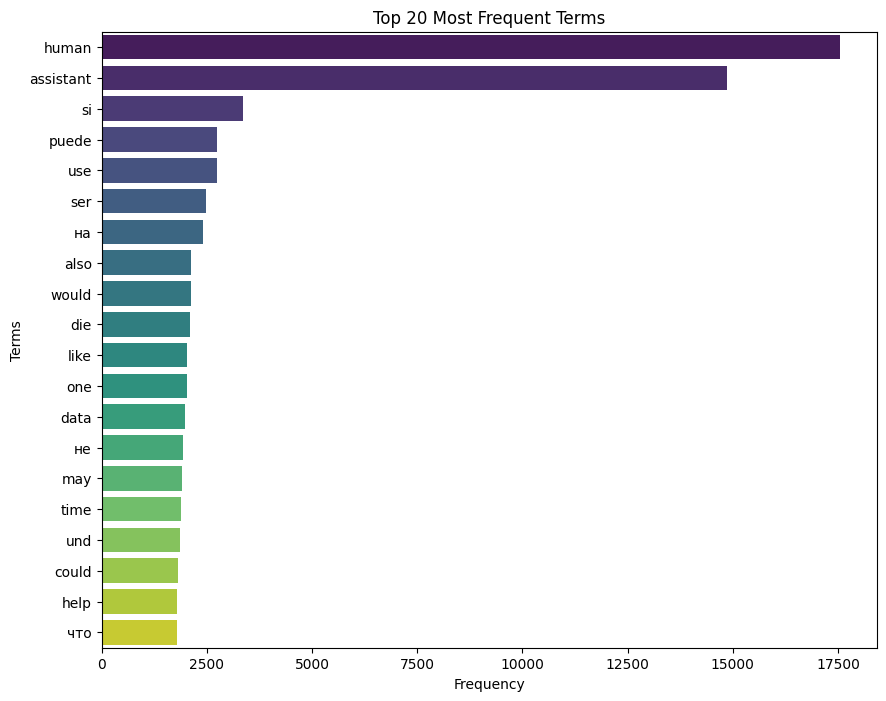

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum up the counts of each term in all documents
sums = X.sum(axis=0)  # Sum over columns to get total counts for each feature

# Connecting term names with their sums
freq = [(word, sums[0, idx]) for word, idx in zip(feature_names, range(sums.shape[1]))]
# Sorting the list of tuples by frequency
sorted_freq = sorted(freq, key=lambda x: x[1], reverse=True)

# Creating DataFrame from the sorted frequencies for easier plotting
freq_df = pd.DataFrame(sorted_freq, columns=["term", "frequency"])

# Plotting the top N most frequent terms
top_n = 20
plt.figure(figsize=(10, 8))  # Set the figure size
sns.barplot(data=freq_df.head(top_n), x="frequency", y="term", palette="viridis")
plt.title("Top 20 Most Frequent Terms")
plt.xlabel("Frequency")
plt.ylabel("Terms")
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_14740\3825800366.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=freq_df.head(top_n), x="frequency", y="term", size="frequency", sizes=(100, 1000), palette="viridis")


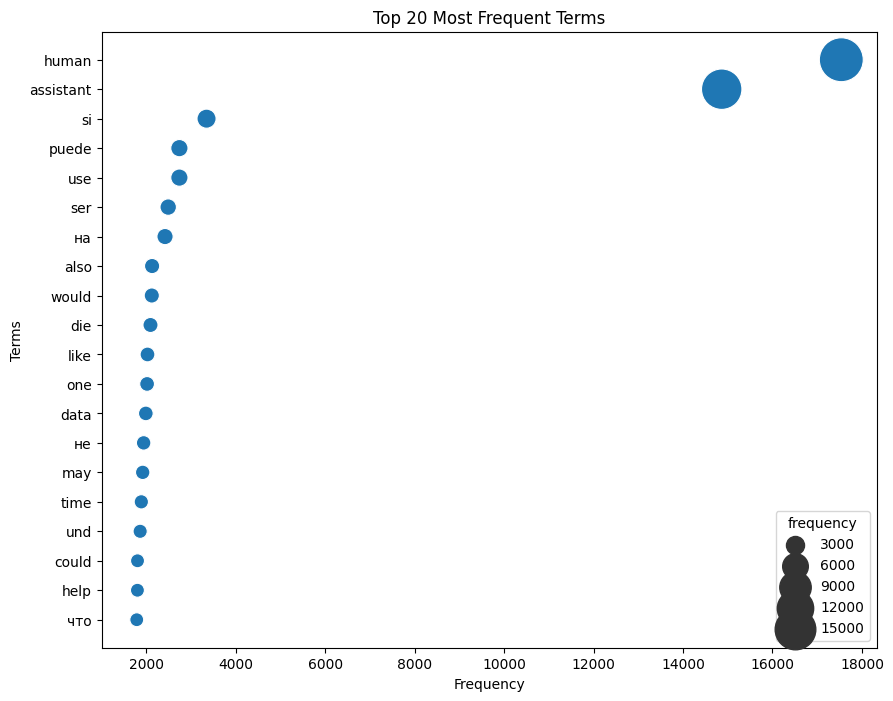

In [54]:
# make another plot with the most frequent terms that most frequently appear like bubble chart, use data which you have

# Plotting the top N most frequent terms

plt.figure(figsize=(10, 8))  # Set the figure size

sns.scatterplot(data=freq_df.head(top_n), x="frequency", y="term", size="frequency", sizes=(100, 1000), palette="viridis")
plt.title("Top 20 Most Frequent Terms")
plt.xlabel("Frequency")
plt.ylabel("Terms")
plt.show()
